In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
# from pprint import pprint
import seaborn as sns

from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import ElasticNet, LinearRegression
from sklearn.pipeline import Pipeline

from sklearn.preprocessing import (
    OrdinalEncoder,
    OneHotEncoder,
    PolynomialFeatures,
    PowerTransformer,
    RobustScaler,
    StandardScaler,
    QuantileTransformer,
)

from src.config import DADOS_LIMPOS
from src.auxiliares import dataframe_coeficientes

from src.graficos import (
    plot_coeficientes,
    plot_comparar_metricas_modelos,
    plot_residuos_estimador,
)

from src.models import (
    organiza_resultados,
    treinar_e_validar_modelo_regressao,
    grid_search_cv_regressor,
)

In [2]:
df = pd.read_parquet(DADOS_LIMPOS)

df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,median_income_cat,population_cat,housing_median_age_cat,rooms_per_household,population_per_household,bedrooms_per_room
0,-122.230003,37.880001,41,880,129,322,126,8.3252,452600,NEAR BAY,5,1,3,6.984127,2.555556,0.146591
1,-122.220001,37.860001,21,7099,1106,2401,1138,8.3014,358500,NEAR BAY,5,4,2,6.238137,2.109842,0.155797
2,-122.260002,37.840000,42,2555,665,1206,595,2.0804,226700,NEAR BAY,2,2,3,4.294117,2.026891,0.260274
3,-122.260002,37.849998,50,1120,283,697,264,2.1250,140000,NEAR BAY,2,1,4,4.242424,2.640152,0.252679
4,-122.260002,37.840000,50,2239,455,990,419,1.9911,158700,NEAR BAY,2,2,4,5.343676,2.362768,0.203216


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17564 entries, 0 to 17563
Data columns (total 16 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   longitude                 17564 non-null  float32 
 1   latitude                  17564 non-null  float32 
 2   housing_median_age        17564 non-null  int8    
 3   total_rooms               17564 non-null  int16   
 4   total_bedrooms            17564 non-null  int16   
 5   population                17564 non-null  int16   
 6   households                17564 non-null  int16   
 7   median_income             17564 non-null  float32 
 8   median_house_value        17564 non-null  int32   
 9   ocean_proximity           17564 non-null  category
 10  median_income_cat         17564 non-null  int64   
 11  population_cat            17564 non-null  int64   
 12  housing_median_age_cat    17564 non-null  int64   
 13  rooms_per_household       17564 non-null  floa

In [ ]:
# df['median_income_cat'] = pd.Categorical(df['median_income_cat'], ordered=True)
# df['population_cat'] = pd.Categorical(df['population_cat'], ordered=True)
# df['housing_median_age_cat'] = pd.Categorical(df['housing_median_age_cat'], ordered=True)

colunas_exluir = ['population_cat', 'housing_median_age_cat',]

df.drop(columns=colunas_exluir, inplace=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17564 entries, 0 to 17563
Data columns (total 14 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   longitude                 17564 non-null  float32 
 1   latitude                  17564 non-null  float32 
 2   housing_median_age        17564 non-null  int8    
 3   total_rooms               17564 non-null  int16   
 4   total_bedrooms            17564 non-null  int16   
 5   population                17564 non-null  int16   
 6   households                17564 non-null  int16   
 7   median_income             17564 non-null  float32 
 8   median_house_value        17564 non-null  int32   
 9   ocean_proximity           17564 non-null  category
 10  median_income_cat         17564 non-null  int64   
 11  rooms_per_household       17564 non-null  float32 
 12  population_per_household  17564 non-null  float32 
 13  bedrooms_per_room         17564 non-null  floa

In [5]:
coluna_target = ['median_house_value',]

coluna_one_hot_encoder = ['ocean_proximity',]

coluna_ordinal_encoder = ['median_income_cat',] # + colunas_exluir

In [6]:
colunas_robust_scaler = df.columns.difference(coluna_target + coluna_one_hot_encoder + coluna_ordinal_encoder).to_list()
print('colunas_robust_scaler =', colunas_robust_scaler)

colunas_robust_scaler = ['bedrooms_per_room', 'households', 'housing_median_age', 'latitude', 'longitude', 'median_income', 'population', 'population_per_household', 'rooms_per_household', 'total_bedrooms', 'total_rooms']


In [7]:
colunas_standard_scaler = ['longitude', 'latitude', 'housing_median_age',]
print('colunas_standard_scaler =', colunas_standard_scaler)

# colunas_power_transformer = colunas_robust_scaler.difference(colunas_standard_scaler) # se fosse um objeto np.array
colunas_power_transformer = [
    coluna for coluna in colunas_robust_scaler
        if coluna not in colunas_standard_scaler
]
print('colunas_power_transformer =', colunas_power_transformer)

colunas_standard_scaler = ['longitude', 'latitude', 'housing_median_age']
colunas_power_transformer = ['bedrooms_per_room', 'households', 'median_income', 'population', 'population_per_household', 'rooms_per_household', 'total_bedrooms', 'total_rooms']


In [8]:
preprocessamento_categoricas = ColumnTransformer(
    transformers=[
        ('ordinal_encoder', OrdinalEncoder(categories='auto'), coluna_ordinal_encoder),
        ('one_hot', OneHotEncoder(drop='first'), coluna_one_hot_encoder),
    ],
    remainder='passthrough',
)

preprocessamento_simples = ColumnTransformer(
    transformers=[
        ('ordinal_encoder', OrdinalEncoder(categories='auto'), coluna_ordinal_encoder),
        ('one_hot', OneHotEncoder(drop='first'), coluna_one_hot_encoder),
        ('robust_scaler', RobustScaler(), colunas_robust_scaler),
    ],
)

preprocessamento_completo = ColumnTransformer(
    transformers=[
        ('ordinal_encoder', OrdinalEncoder(categories='auto'), coluna_ordinal_encoder),
        ('one_hot', OneHotEncoder(drop='first'), coluna_one_hot_encoder),
        ('scaler', StandardScaler(), colunas_standard_scaler),
        ('power_transformer', PowerTransformer(), colunas_power_transformer),
    ],
)


In [9]:
X = df.drop(columns=coluna_target)
y = df[coluna_target]

In [ ]:
X.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,median_income_cat,rooms_per_household,population_per_household,bedrooms_per_room
0,-122.230003,37.880001,41,880,129,322,126,8.3252,NEAR BAY,5,6.984127,2.555556,0.146591
1,-122.220001,37.860001,21,7099,1106,2401,1138,8.3014,NEAR BAY,5,6.238137,2.109842,0.155797
2,-122.260002,37.840000,42,2555,665,1206,595,2.0804,NEAR BAY,2,4.294117,2.026891,0.260274
3,-122.260002,37.849998,50,1120,283,697,264,2.1250,NEAR BAY,2,4.242424,2.640152,0.252679
4,-122.260002,37.840000,50,2239,455,990,419,1.9911,NEAR BAY,2,5.343676,2.362768,0.203216


In [11]:
y.head()

,median_house_value
0,452600
1,358500
2,226700
3,140000
4,158700


In [12]:
param_grid = {
    'regressor__preprocessor': [preprocessamento_categoricas, preprocessamento_simples, preprocessamento_completo,],

    # transformer é um parametro da função sklearn.compose.TransformedTargetRegressor()
    'transformer': [None, PowerTransformer(), QuantileTransformer(output_distribution='normal')],
}

param_grid

{'regressor__preprocessor': [ColumnTransformer(remainder='passthrough',
                    transformers=[('ordinal_encoder', OrdinalEncoder(),
                                   ['median_income_cat']),
                                  ('one_hot', OneHotEncoder(drop='first'),
                                   ['ocean_proximity'])]),
  ColumnTransformer(transformers=[('ordinal_encoder', OrdinalEncoder(),
                                   ['median_income_cat']),
                                  ('one_hot', OneHotEncoder(drop='first'),
                                   ['ocean_proximity']),
                                  ('robust_scaler', RobustScaler(),
                                   ['bedrooms_per_room', 'households',
                                    'housing_median_age', 'latitude', 'longitude',
                                    'median_income', 'population',
                                    'population_per_household',
                                    'rooms_per_

In [13]:
grid_search = grid_search_cv_regressor(
    regressor=LinearRegression(),
    preprocessor=preprocessamento_completo,
    target_transformer=PowerTransformer(),
    param_grid=param_grid,
)

grid_search

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=TransformedTargetRegressor(regressor=Pipeline(steps=[('preprocessor',
                                                                             ColumnTransformer(transformers=[('ordinal_encoder',
                                                                                                              OrdinalEncoder(),
                                                                                                              ['median_income_cat']),
                                                                                                             ('one_hot',
                                                                                                              OneHotEncoder(drop='first'),
                                                                                                              ['ocean_proximity']),
                                                                                                             ('scaler',
                                                                                                              StandardScaler(),
                                                                                                              ['longitude',
                                                                                                               'latitude',
                                                                                                               'housi...
                                                                                      ['bedrooms_per_room',
                                                                                       'households',
                                                                                       'median_income',
                                                                                       'population',
                                                                                       'population_per_household',
                                                                                       'rooms_per_household',
                                                                                       'total_bedrooms',
                                                                                       'total_rooms'])])],
                         'transformer': [None, PowerTransformer(),
                                         QuantileTransformer(output_distribution='normal')]},
             refit='neg_root_mean_squared_error',
             scoring=['r2', 'neg_mean_absolute_error',
                      'neg_root_mean_squared_error'],
             verbose=1)

In [14]:
X[['longitude', 'latitude', 'rooms_per_household', 'population_per_household', 'bedrooms_per_room', 'median_income',]] =\
    X[['longitude', 'latitude', 'rooms_per_household', 'population_per_household', 'bedrooms_per_room', 'median_income',]]\
        .astype(np.float64, copy=True)
X[['housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households',]] =\
    X[['housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households',]].astype(np.int64, copy=True)

X.info()





<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17564 entries, 0 to 17563
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   longitude                 17564 non-null  float64 
 1   latitude                  17564 non-null  float64 
 2   housing_median_age        17564 non-null  int64   
 3   total_rooms               17564 non-null  int64   
 4   total_bedrooms            17564 non-null  int64   
 5   population                17564 non-null  int64   
 6   households                17564 non-null  int64   
 7   median_income             17564 non-null  float64 
 8   ocean_proximity           17564 non-null  category
 9   median_income_cat         17564 non-null  int64   
 10  rooms_per_household       17564 non-null  float64 
 11  population_per_household  17564 non-null  float64 
 12  bedrooms_per_room         17564 non-null  float64 
dtypes: category(1), float64(6), int64(6)
memory us

In [15]:
grid_search.fit(X, y)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=TransformedTargetRegressor(regressor=Pipeline(steps=[('preprocessor',
                                                                             ColumnTransformer(transformers=[('ordinal_encoder',
                                                                                                              OrdinalEncoder(),
                                                                                                              ['median_income_cat']),
                                                                                                             ('one_hot',
                                                                                                              OneHotEncoder(drop='first'),
                                                                                                              ['ocean_proximity']),
                                                                                                             ('scaler',
                                                                                                              StandardScaler(),
                                                                                                              ['longitude',
                                                                                                               'latitude',
                                                                                                               'housi...
                                                                                      ['bedrooms_per_room',
                                                                                       'households',
                                                                                       'median_income',
                                                                                       'population',
                                                                                       'population_per_household',
                                                                                       'rooms_per_household',
                                                                                       'total_bedrooms',
                                                                                       'total_rooms'])])],
                         'transformer': [None, PowerTransformer(),
                                         QuantileTransformer(output_distribution='normal')]},
             refit='neg_root_mean_squared_error',
             scoring=['r2', 'neg_mean_absolute_error',
                      'neg_root_mean_squared_error'],
             verbose=1)

In [16]:
grid_search.best_params_

{'regressor__preprocessor': ColumnTransformer(transformers=[('ordinal_encoder', OrdinalEncoder(),
                                  ['median_income_cat']),
                                 ('one_hot', OneHotEncoder(drop='first'),
                                  ['ocean_proximity']),
                                 ('robust_scaler', RobustScaler(),
                                  ['bedrooms_per_room', 'households',
                                   'housing_median_age', 'latitude', 'longitude',
                                   'median_income', 'population',
                                   'population_per_household',
                                   'rooms_per_household', 'total_bedrooms',
                                   'total_rooms'])]),
 'transformer': QuantileTransformer(output_distribution='normal')}

In [17]:
grid_search.best_score_

np.float64(-54424.32021194456)

In [18]:
coefs = dataframe_coeficientes(
    grid_search.best_estimator_.regressor_['reg'].coef_,
    grid_search.best_estimator_.regressor_['preprocessor'].get_feature_names_out(),
)

coefs

,coeficiente
robust_scaler__latitude,-1.080909
robust_scaler__longitude,-1.068808
one_hot__ocean_proximity_INLAND,-0.453736
robust_scaler__population_per_household,-0.235082
one_hot__ocean_proximity_NEAR BAY,-0.204536
robust_scaler__total_rooms,-0.099127
robust_scaler__total_bedrooms,-0.080697
one_hot__ocean_proximity_NEAR OCEAN,-0.059433
robust_scaler__population,-0.033664
ordinal_encoder__median_income_cat,0.035659


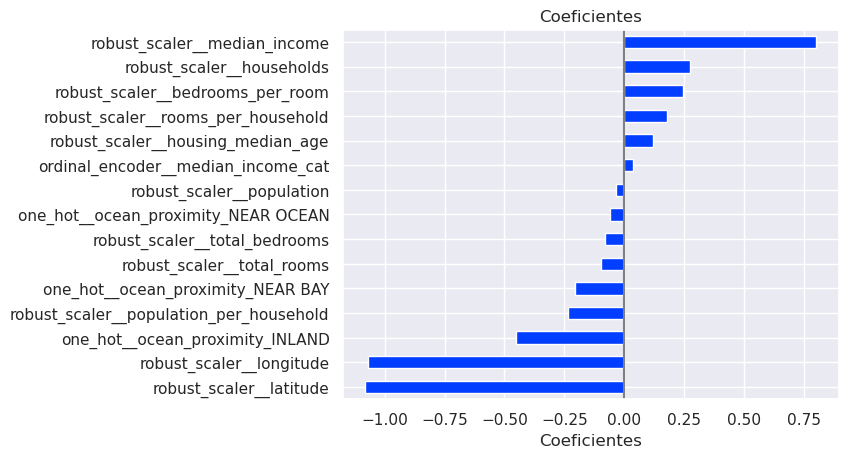

In [19]:
plot_coeficientes(coefs)

In [20]:
regressors = {
    'LinearRegression': {
        'preprocessor': preprocessamento_categoricas,
        'regressor': LinearRegression(),
        'target_transformer': None,
    },

    'LinearRegression_grid_search': {
        'preprocessor': grid_search.best_estimator_.regressor_['preprocessor'],
        'regressor': grid_search.best_estimator_.regressor_['reg'],
        'target_transformer': grid_search.best_estimator_.transformer_,
    },
}

In [21]:
resultados = {
    nome_modelo: treinar_e_validar_modelo_regressao(X=X, y=y, **regressor)
        for nome_modelo, regressor in regressors.items()
}

df_resultados = organiza_resultados(resultados)

df_resultados

,model,fit_time,score_time,test_r2,test_neg_mean_absolute_error,test_neg_root_mean_squared_error,time_seconds
0,LinearRegression,0.091038,0.066418,0.682162,-39855.690921,-54254.958115,0.157456
1,LinearRegression,0.062353,0.019453,0.66999,-40272.565406,-54695.230224,0.081807
2,LinearRegression,0.057085,0.021788,0.649247,-42178.059246,-56955.988686,0.078873
3,LinearRegression,0.054822,0.021256,0.669873,-40806.492452,-55146.31876,0.076078
4,LinearRegression,0.058188,0.021,0.669023,-40788.496555,-55331.351171,0.079188
5,LinearRegression_grid_search,0.116337,0.023661,0.691585,-37818.120294,-53444.652665,0.139997
6,LinearRegression_grid_search,0.10654,0.03318,0.678173,-38297.325698,-54012.810879,0.13972
7,LinearRegression_grid_search,0.091372,0.024983,0.653954,-40290.857558,-56572.474308,0.116355
8,LinearRegression_grid_search,0.091478,0.026738,0.683795,-38604.078044,-53971.04591,0.118216
9,LinearRegression_grid_search,0.087853,0.04573,0.681964,-38416.34921,-54238.833169,0.133583


In [22]:
df_resultados.groupby('model').mean().T

model,LinearRegression,LinearRegression_grid_search
fit_time,0.064697,0.098716
score_time,0.029983,0.030858
test_r2,0.668059,0.677894
test_neg_mean_absolute_error,-40780.260916,-38685.346161
test_neg_root_mean_squared_error,-55276.769391,-54447.963386
time_seconds,0.09468,0.129574


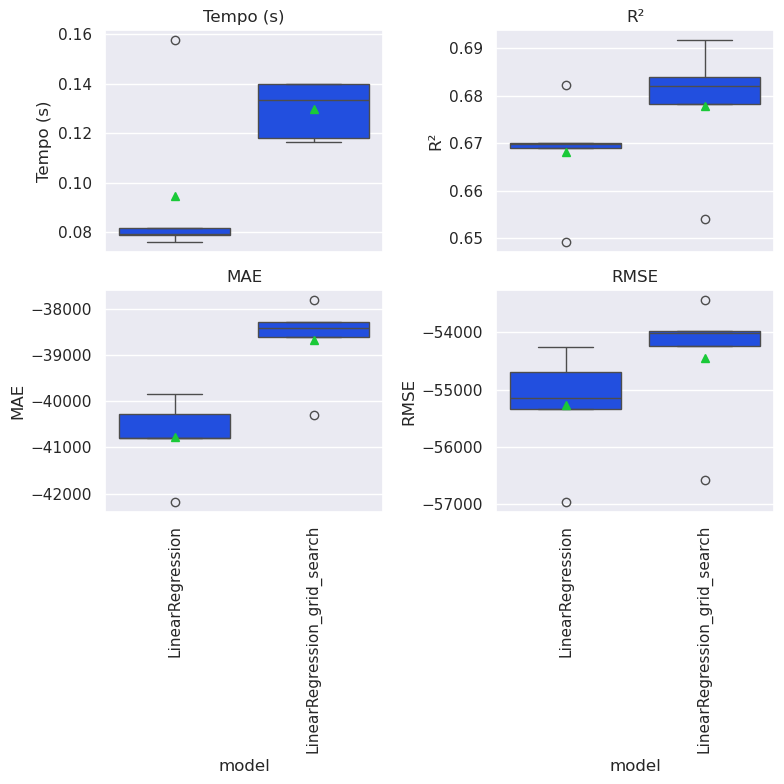

In [23]:
plot_comparar_metricas_modelos(df_resultados)

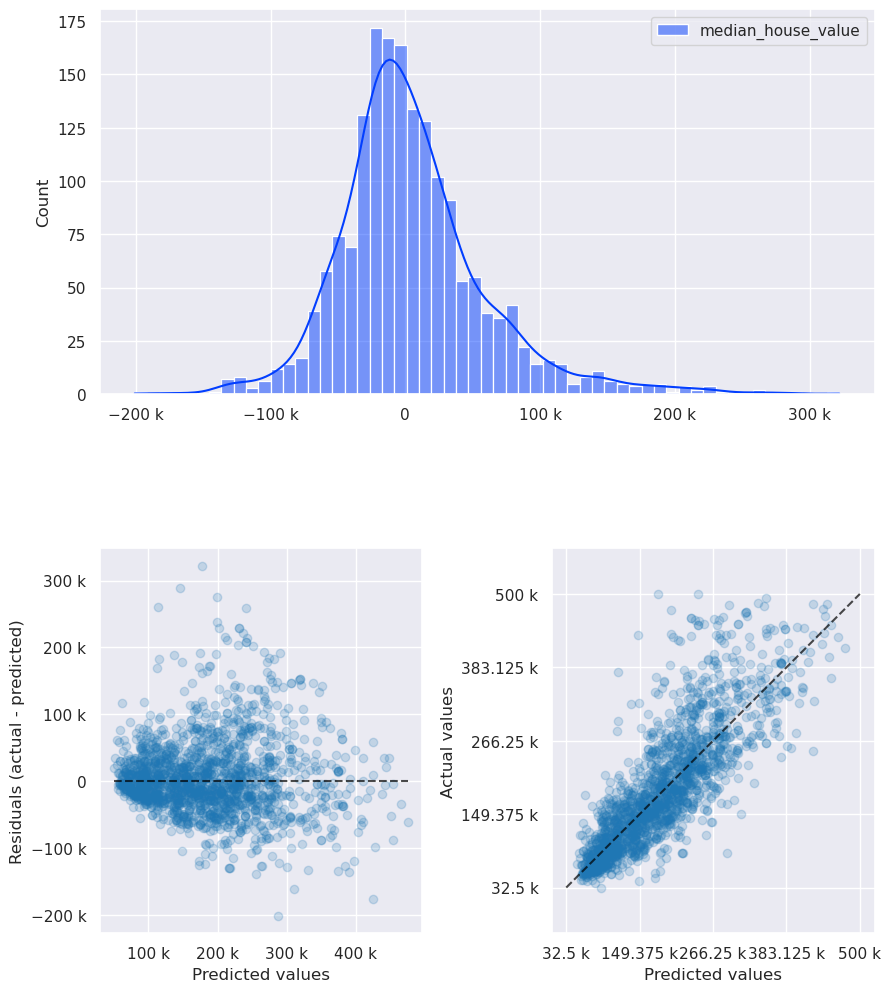

In [24]:
plot_residuos_estimador(
    estimator=grid_search.best_estimator_,
    X=X,
    y=y,
    eng_formatter=True,
    fracao_amostra=0.1,
)